In [106]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import OneHotEncoder,StandardScaler
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [37]:

df= pd.read_csv('spam_utf8.csv')
df.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [38]:
df=df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])

In [39]:
df=df.rename(columns={'v1':'type','v2':'message'})
df.head()

,type,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [24]:
df['message']=df['message'].str.lower()
df.head()

,type,message
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


In [26]:
df['len_type']=df['type'].str.len()
df['len_message']=df['message'].str.len()

In [116]:
print(df['len_type'].unique())
df.shape

[3 4]


(5572, 4)

In [109]:
df['message'] = df['message'].apply(lambda x: re.sub(r'\d+', '', str(x)))
df['message'] = df['message'].apply(lambda x: re.sub('[^a-zA-Z ]', ' ', str(x).lower()))
df['message'] = df['message'].apply(lambda x: re.sub('\s+', ' ', x).strip())
df['message']
df['type']=df['type'].replace({'ham':0,'spam':1})
df['type']

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: type, Length: 5572, dtype: int64

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [111]:
tfidf = TfidfVectorizer()

x=tfidf.fit_transform(df['message'])


In [112]:
x_train,x_test,y_train,y_test=train_test_split(x,df['type'],test_size=0.2,random_state=43)

model=SVC(kernel='rbf')
model.fit(x_train,y_train)
pred=model.predict(x_test)
print('Accuracy : ',np.round(accuracy_score(y_test,pred)*100,2),'%')

Accuracy :  97.22 %


Accuracy :  97.94 %
[[958   2]
 [ 21 134]]


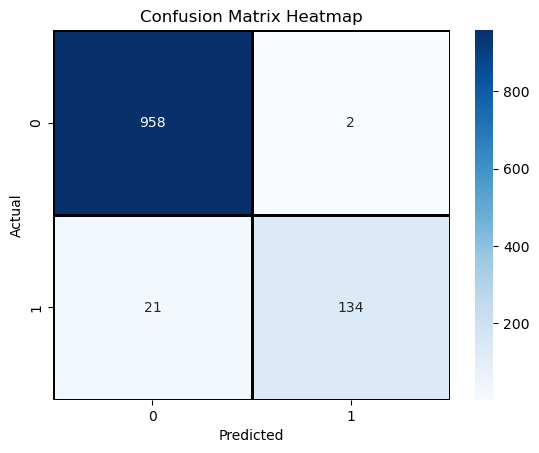

In [113]:
preprocess=ColumnTransformer(
    transformers=[
        ('tfidf',TfidfVectorizer(),'message')
])
pipe=Pipeline([
    ('step',preprocess),
    ('model',SVC(kernel="rbf"))
])
x=df[['message']]
y=df['type']


x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=43)
# print(x_train,x_test,y_train,y_test)
pipe.fit(x_train,y_train)
pred=pipe.predict(x_test)



print('Accuracy : ',np.round(accuracy_score(y_test,pred)*100,2),'%')
mat = confusion_matrix(y_test,pred)
print(mat)
sns.heatmap(mat,annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()



In [114]:
scores=cross_val_score(pipe,x,y,cv=10)
print('Score :',scores.mean()*100)
print(scores * 100)

Score : 98.20534352618677
[98.92473118 97.31182796 98.20466786 98.38420108 97.84560144 98.02513465
 98.20466786 98.02513465 98.20466786 98.92280072]


In [115]:
messages=['Congratulations! You won a free iPhone, click the link to claim now!','Hey bro, are we meeting tomorrow for class?']

result=pipe.predict(pd.DataFrame({
    'message':messages
}))
print(result)

[1 0]


In [118]:
import joblib
joblib.dump(pipe,'spam_message_detect.pkl')

['spam_message_detect.pkl']

In [121]:
message=['Congratulations! You won a free iPhone, click the link to claim now!']

pipe=joblib.load('spam_message_detect.pkl')
result=pipe.predict(pd.DataFrame({
    'message':message
}))[0]
if result==0:
    print('Not Spam Message')
else:
    print('SPAM Message')


SPAM Message
